In [1]:
from DataProcessing import LUNA
%matplotlib inline

import pydicom as dc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import pandas as pd
import xml
from xml.etree import ElementTree
from shapely.geometry import Polygon
from shapely.geometry import Point

luna = LUNA()

Training Data found: 1595
Evaluation Data found: 1595
XML Training Data found: 18
XML Evaluation Data found: 18


In [92]:
from random import randint
import util as ut
j = 0
path = ''
xml_path = ''
path_list = []
z_position = 0
annotations = np.zeros(shape=(512,512))
nodules = np.zeros(shape=(512,512))
while j<1000:
    xml_path = luna.xml_training_list[randint(0, luna.xml_training_list_length-1)]
    if luna.valid_xml(xml_path):
        f = ElementTree.parse(xml_path).getroot()
        docs = f.findall('{http://www.nih.gov}readingSession')
        nodules = docs[randint(0, len(docs)-1)].findall('{http://www.nih.gov}unblindedReadNodule')
        nod = nodules[randint(0,len(nodules)-1)]
        slices= nod.findall('{http://www.nih.gov}roi')
        slice = slices[randint(0,len(slices)-1)]
        z_position = float(slice[0].text)
        id = slice[1].text
        if len(slice.findall('{http://www.nih.gov}edgeMap')) > 10:
            # read out annotation map of chosen nodule
            annotations = np.zeros(shape=(512,512))
            nodules = np.zeros(shape=(512,512))
            vertices = []
            for coord in slice.findall('{http://www.nih.gov}edgeMap'):
                #print((int(coord[1].text), int(coord[0].text)))
                vertices.append((int(coord[1].text), int(coord[0].text)))                
                annotations[int(coord[1].text), int(coord[0].text)] = 1
                nodules[int(coord[1].text), int(coord[0].text)] = 1
            try:
                poly = Polygon(vertices)
                bnd = poly.bounds
                for x in range(int(bnd[0]), int(bnd[2] + 1)):
                    for y in range(int(bnd[1]), int(bnd[3] + 1)):
                        point = Point(x, y)
                        if point.within(poly):
                            nodules[x, y] = 1
                j = 1000
                
            except ValueError:
                nodules = annotations
                print('Polygone filling failed. Draw new nodule')
    j = j+1
    print(j)
    
k = -1
while (not xml_path[k] == '/') and k > -1000:
    k = k - 1
last_number = len(xml_path) + k
cut_path = xml_path[0:last_number]
path_list = ut.find('*dcm', cut_path)

### find the centre of the nodule
x_min = 512
x_max = 0
y_min = 512
y_max = 0
for coord in vertices:
    if coord[0] < x_min:
        x_min = coord[0]
    if coord[0] > x_max:
        x_max = coord[0]
    if coord[1] < y_min:
        y_min = coord[1]
    if coord[1] > y_max:
        y_max = coord[1]
x_cen = int((x_min + x_max) / 2)
y_cen = int((y_min + y_max) / 2)

print((x_min, x_max, y_min, y_max))

### find image in path_list that fits the z position and id of the chosen nodule
for im_path in path_list:
    dc_file = dc.read_file(im_path)
    image_z = (dc_file[0x0020, 0x0032].value)[2]
    image_id = dc_file[0x0008, 0x0018].value
    if image_z == z_position:
        path = im_path
        assert image_id == id

dc_file = dc.read_file(path)

pic = dc_file.pixel_array
print(np.max(pic))
print(np.min(pic))

def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 800.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image


pic =normalize(pic)

print(np.max(pic))
print(np.min(pic))



1
2
3
4
5
(302, 189)
(301, 190)
(301, 191)
(301, 192)
(301, 193)
(301, 194)
(301, 195)
(301, 196)
(301, 197)
(301, 198)
(300, 198)
(299, 199)
(298, 199)
(297, 200)
(297, 201)
(297, 202)
(297, 203)
(297, 204)
(296, 205)
(295, 205)
(294, 206)
(294, 207)
(294, 208)
(293, 209)
(292, 210)
(292, 211)
(291, 211)
(290, 211)
(289, 211)
(288, 211)
(287, 211)
(286, 211)
(285, 210)
(284, 210)
(283, 210)
(282, 209)
(281, 209)
(280, 208)
(279, 207)
(278, 208)
(277, 208)
(276, 208)
(275, 207)
(275, 206)
(276, 205)
(276, 204)
(276, 203)
(276, 202)
(276, 201)
(275, 200)
(275, 199)
(275, 198)
(275, 197)
(276, 196)
(276, 195)
(277, 194)
(277, 193)
(277, 192)
(276, 191)
(276, 190)
(276, 189)
(277, 188)
(277, 187)
(277, 186)
(276, 185)
(276, 184)
(276, 183)
(276, 182)
(276, 181)
(276, 180)
(276, 179)
(276, 178)
(276, 177)
(276, 176)
(277, 175)
(278, 174)
(279, 173)
(280, 173)
(281, 173)
(282, 174)
(283, 174)
(284, 175)
(283, 175)
(282, 176)
(282, 177)
(283, 178)
(284, 179)
(285, 179)
(286, 179)
(287, 179)


1001
(275, 302, 173, 211)


4095
-1024
1.0
0.0


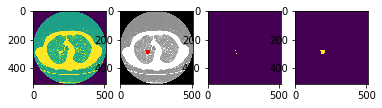

In [93]:
size = pic.shape
three_c = np.zeros(shape=[size[0], size[1], 3])
for k in range(3):
    three_c[...,k] = pic
    
# set red chanel to 1 whenever in nodules and set all other channels to 0
for x in range(size[0]):
    for y in range(size[1]):
        if nodules[x,y]==1:
            three_c[x,y,0] = 1
            three_c[x,y,1] = 0
            three_c[x,y,2] = 0
            
three_c_m = np.zeros(shape=[size[0], size[1], 3])
for k in range(3):
    three_c_m[...,k] = pic

   

    
plt.figure()
plt.subplot(141)
plt.imshow(pic)
plt.subplot(142)
plt.imshow(three_c)
plt.subplot(143)
plt.imshow(annotations)
plt.subplot(144)
plt.imshow(nodules)
plt.show()

In [92]:
### cut out patches used for segmentation


In [31]:
import tensorflow as tf
from Networks import UNet_segmentation
sess = tf.InteractiveSession()

net = UNet_segmentation( size = (512,512), colors=1)

input_image = tf.placeholder(shape=(None, 512, 512, 1), dtype=tf.float32)
input_seg = tf.placeholder(shape=(None, 512, 512, 1), dtype=tf.float32)

output_seg = net.net(input_image)

/usr/local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


ValueError: Variable pre1/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/Users/seb/Projects/TaskBasedRecon/Networks.py", line 152, in raw_net
    padding="same", name='pre1', reuse=reuse, activation=tf.nn.relu)
  File "/Users/seb/Projects/TaskBasedRecon/Networks.py", line 182, in net
    output = self.raw_net(input, reuse=self.used)
  File "<ipython-input-3-a7bc9c365622>", line 10, in <module>
    output_seg = net.net(input_image)


In [32]:
loss1 = - tf.reduce_mean(tf.multiply(tf.log(output_seg), input_seg))
loss2 = - tf.reduce_mean(tf.multiply(tf.log(1-output_seg), 1-input_seg))
loss  = 100*loss1 + loss2